# Geospatial Raster Data in Python

**Attribution**: *Parts of this tutorial are developed based on the content from the following great sources: Parts of this tutorial are developed based on the content from the following great sources: [Introduction to Python for Geographic Data AnalysisIntroduction to Python for Geographic Data Analysis](https://pythongis.org/part2/chapter-07/nb/01-reading-raster.html); [Introduction to Raster Data in PythonIntroduction to Raster Data in Python](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/); and [Introduction to Geospatial Raster and Vector Data with PythonIntroduction to Geospatial Raster and Vector Data with Python](https://carpentries-incubator.github.io/geospatial-python/index.html)*

The purpose of this lecture is to learn `rasterio` and `rioxarray` for loading and working with raster data.

You can access this notebook (in a Docker image) on this [GitHub repo](https://github.com/HamedAlemo/raster-data-tutorial).



## Find a Satellite Scene

First, Let's find a Sentinel-2 scene to work with. We will use the `PySTAC` client to retrieve the latest cloud free scene across Clark University campus: 

In [1]:
import pystac_client
import planetary_computer

def retrieve_latest_stac_item(url, collection, point, pc_flag = False, query = None): 
    """
    This function retrieves the latest STAC item from a STAC API
    
    Parameters
    ----------
    url : str
        The STAC API URL
    collection : str
        Collection ID to search in the STAC API
    point : dict
       A GeoJOSN Point feature with coordinates of the target point for API search
    pc_flag : boolean
        A boolean flag to specify whether the STAC API is Microsoft's planetary computer API. Default is set to False.
    query : list
        A list of query parameters for STAC API. Default is set to None. 

    Returns
    -------
    items : Generator
        The STAC item that has the latest date of acquisition given all the query parameters. 
        
    """
    if pc_flag:
        modifier = planetary_computer.sign_inplace
    else:
        modifier = None
        
    catalog = pystac_client.Client.open(
        url = url,
        modifier = modifier,
    )

    search_results = catalog.search(
        collections = [collection],
        intersects = point,
        query = query,
        sortby = ["-properties.datetime"],
        max_items = 1
    )
    item = search_results.item_collection()

    return item

In [2]:
# A point in Clark campus:
point = dict(type="Point", coordinates=(-71.822833, 42.250809))

# Query parameters for low cloud cover and high missing pixels.
query = ["eo:cloud_cover<5", "s2:nodata_pixel_percentage>20"]

In [3]:
item = retrieve_latest_stac_item(url = "https://earth-search.aws.element84.com/v1",
                                 collection = "sentinel-2-l2a",
                                 point = point, 
                                 query = query
                                )      

(Note that we also added `s2:nodata_pixel_percentage` to our query parameters to find scenes that have some missing pixels. We want to use these to demonstrate how you would handle missing data later on)

## Working with Rasterio

[Rasterio](https://rasterio.readthedocs.io/en/stable/) is a highly useful module for raster processing which you can use for reading and writing several different raster formats in Python. `Rasterio` is based on [GDAL](https://gdal.org/) and Python automatically registers all known GDAL drivers for reading supported formats when importing the module.

### Read the Metadata

In [4]:
import rasterio
import os
import numpy as np

Let's open the `nir` band of the first item:

In [5]:
worcester_nir = rasterio.open(item[0].assets["nir"].href)

And let's see what is the type of `worcester_nir`:


In [6]:
type(worcester_nir)

rasterio.io.DatasetReader

You can see that our raster variable is a `rasterio.io.DatasetReader` type which means that we have opened the file for reading. This does not contain the value of the bands yet. 

You can retrieve the metadata of this raster as following:

In [7]:
print("CRS of the scene is:", worcester_nir.crs)
print("Transform of the scene is:", worcester_nir.transform)
print("Width of the scene is:", worcester_nir.width)
print("Height of the scene is:", worcester_nir.height)
print("Number of bands in the scene is:", worcester_nir.count)
print("Bounds of the scene are:", worcester_nir.bounds)
print("The no data values for all channels are:", worcester_nir.nodatavals)

CRS of the scene is: EPSG:32618
Transform of the scene is: | 10.00, 0.00, 699960.00|
| 0.00,-10.00, 4700040.00|
| 0.00, 0.00, 1.00|
Width of the scene is: 10980
Height of the scene is: 10980
Number of bands in the scene is: 1
Bounds of the scene are: BoundingBox(left=699960.0, bottom=4590240.0, right=809760.0, top=4700040.0)
The no data values for all channels are: (0.0,)


If you need a reminder about what `transform` is, check this [reference](https://www.perrygeo.com/python-affine-transforms.html).

Alternatively, you can retrieve all metadata of the scene using the following:

In [8]:
print("All metadata of the scene:")
print(worcester_nir.meta)

All metadata of the scene:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(10.0, 0.0, 699960.0,
       0.0, -10.0, 4700040.0)}


### Exercise 1
You can retrieve the same metadata from the STAC item properties. Write a code that prints the same metadata as printed in the previous cell but using the STAC item properties:

### Get Band Data

You can read the data from one or multiple bands using the `read` method:

In [9]:
nir = worcester_nir.read(1)

**Note**: rasterio band numbering starts from `1` unlike Python that starts from `0`.

Let's examine the data type this band:

In [10]:
nir

array([[   0,    0,    0, ..., 2750, 3100, 3396],
       [   0,    0,    0, ..., 3392, 4028, 3228],
       [   0,    0,    0, ..., 3608, 3828, 3132],
       ...,
       [   0,    0,    0, ...,    1,    1,    1],
       [   0,    0,    0, ...,   11,    6,    8],
       [   0,    0,    0, ...,    2,    1,    1]], dtype=uint16)

In [11]:
print(nir.dtype)

uint16


This data type is a 16-bit unsigned integer. Unsigned integer is always equal to or greater than zero but signed integer can store negative values too. For example, an unsigned 16-bit integer can store 2^16 (=65,536) values ranging from 0 to 65,535.

### Visualize Band Data

Let's now visualize this band. We can use the `plot` function from `rasterio`:

In [12]:
from rasterio import plot

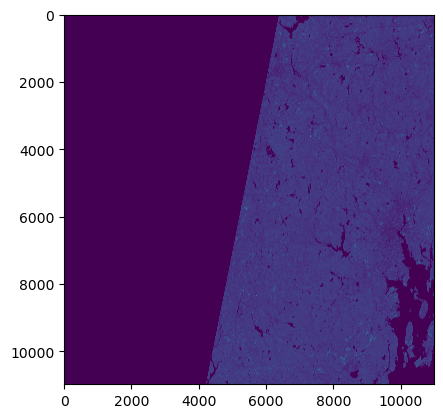

<Axes: >

In [13]:
plot.show(nir)

As you can see in this case the band data is treated as a regular (non-geospatial) array and the axes start from 0 instead of the actual coordinates of the raster. This happens as the `nir` variable is a numpy array and has no geospatial attirbutes. You can use the rasterio dataset `worcester_nir` and get the plot with the actual bounds:

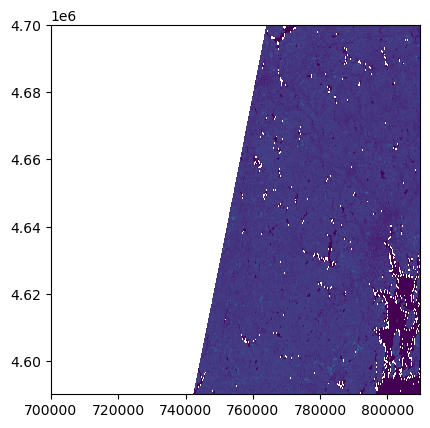

<Axes: >

In [14]:
plot.show(worcester_nir)

## Working with Rioxarray

`rioxarray` is a package based on the popular `rasterio` package for working with rasters and `xarray` for working with multi-dimensional arrays. `rioxarray` extends `xarray` by providing top-level functions (e.g. the `open_rasterio` function to open raster datasets) and by adding a set of methods to the main objects of the xarray package (the `Dataset` and the `DataArray`). These additional methods are made available via the `rio` accessor and become available from `xarray` objects after importing `rioxarray`.

We can implement the steps we carried out with `rasterio` in the previous section using `rioxarray` as following:

In [15]:
import rioxarray as rxr

In [16]:
worcester_nir_xr = rxr.open_rasterio(item[0].assets["nir"].href)

Let's look at the `worcester_nir_xr`:

In [17]:
worcester_nir_xr

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 7e+05 7e+05 7e+05 ... 8.097e+05 8.098e+05
  * y            (y) float64 88kB 4.7e+06 4.7e+06 4.7e+06 ... 4.59e+06 4.59e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

The output tells us that we are looking at an `xarray.DataArray`, with 1 band, 10980 rows, and 10980 columns. We can also see the number of pixel values in the `DataArray`, and the type of those pixel values, which is unsigned integer (or `uint16`). The `DataArray` also stores different values for the coordinates of the `DataArray`. When using `rioxarray`, the term coordinates refers to spatial coordinates like `x` and `y` but also the `band` coordinate. Each of these sequences of values has its own data type, like `int64` for the spatial coordinates and `float64` for the x and y coordinates.

Similar to `rasterio`, we can inspect the attributes of the raster. They can be accessed from the `rio` accessor like `.rio.crs`, `.rio.nodata`, and `.rio.bounds()`, which contain the metadata for the file we opened.

In [18]:
print("CRS of the scene is:", worcester_nir_xr.rio.crs)
print("Transform of the scene is:", worcester_nir_xr.rio.transform())
print("Width of the scene is:", worcester_nir_xr.rio.width)
print("Height of the scene is:", worcester_nir_xr.rio.height)
print("Number of bands in the scene is:", worcester_nir_xr.rio.count)
print("Bounds of the scene are:", worcester_nir_xr.rio.bounds())
print("The no data values for all channels are:", worcester_nir_xr.rio.nodata)

CRS of the scene is: EPSG:32618
Transform of the scene is: | 10.00, 0.00, 699960.00|
| 0.00,-10.00, 4700040.00|
| 0.00, 0.00, 1.00|
Width of the scene is: 10980
Height of the scene is: 10980
Number of bands in the scene is: 1
Bounds of the scene are: (699960.0, 4590240.0, 809760.0, 4700040.0)
The no data values for all channels are: 0


You can get the band data using `.data`:

In [19]:
worcester_nir_xr.data

array([[[   0,    0,    0, ..., 2750, 3100, 3396],
        [   0,    0,    0, ..., 3392, 4028, 3228],
        [   0,    0,    0, ..., 3608, 3828, 3132],
        ...,
        [   0,    0,    0, ...,    1,    1,    1],
        [   0,    0,    0, ...,   11,    6,    8],
        [   0,    0,    0, ...,    2,    1,    1]]], dtype=uint16)

You can also use `.values` to get the band data but `.values` will try to convert the data to `numpy.array` if the data is not in that type (e.g. if it's a `dask.array`). So you should be careful with calling `.values`.

You can also visualize the raster:

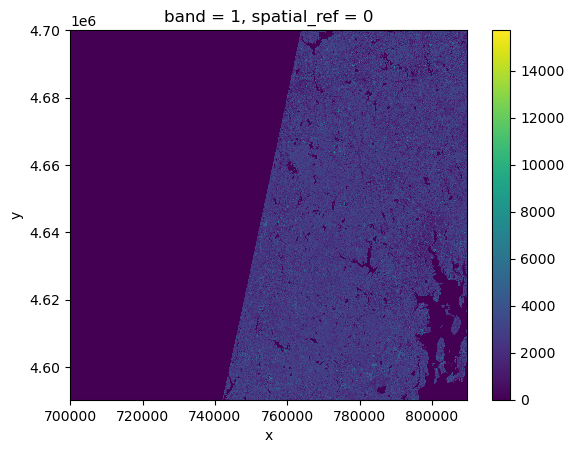

In [20]:
worcester_nir_xr.plot()

You can also use built-in `xarray` functions to calculate statistics of the data:

In [21]:
print("Min of the data is:", worcester_nir_xr.min())
print("Max of the data is:", worcester_nir_xr.max())
print("Mean of the data is:", worcester_nir_xr.mean())
print("Std of the data is:", worcester_nir_xr.std())
print("25th, and 75th quantiles of the data are:", worcester_nir_xr.quantile([0.25, 0.75]))

Min of the data is: <xarray.DataArray ()> Size: 2B
np.uint16(0)
Coordinates:
    spatial_ref  int64 8B 0
Max of the data is: <xarray.DataArray ()> Size: 2B
np.uint16(15720)
Coordinates:
    spatial_ref  int64 8B 0
Mean of the data is: <xarray.DataArray ()> Size: 8B
np.float64(1206.1200808059696)
Coordinates:
    spatial_ref  int64 8B 0
Std of the data is: <xarray.DataArray ()> Size: 8B
np.float64(1371.8201087615394)
Coordinates:
    spatial_ref  int64 8B 0
25th, and 75th quantiles of the data are: <xarray.DataArray (quantile: 2)> Size: 16B
array([   0., 2510.])
Coordinates:
  * quantile  (quantile) float64 16B 0.25 0.75


But there is an issue with these statistics. As you can see in the plot, this scene has a lot of missing pixels that are set to `0` (the nodata value). These are included in the calculation of the stats. 

To avoid this, you need to open the file appropriately as required by `rasterio` to mask those pixels:

In [23]:
worcester_nir_xr_masked = rxr.open_rasterio(item[0].assets["nir"].href, masked=True)

Now let's recalculate the stats:

In [24]:
print("Min of the data is:", worcester_nir_xr_masked.min())
print("Max of the data is:", worcester_nir_xr_masked.max())
print("Mean of the data is:", worcester_nir_xr_masked.mean())
print("Std of the data is:", worcester_nir_xr_masked.std())
print("25th, and 75th quantiles of the data are:", worcester_nir_xr_masked.quantile([0.25, 0.75]))

Min of the data is: <xarray.DataArray ()> Size: 4B
np.float32(1.0)
Coordinates:
    spatial_ref  int64 8B 0
Max of the data is: <xarray.DataArray ()> Size: 4B
np.float32(15720.0)
Coordinates:
    spatial_ref  int64 8B 0
Mean of the data is: <xarray.DataArray ()> Size: 4B
np.float32(2332.955)
Coordinates:
    spatial_ref  int64 8B 0
Std of the data is: <xarray.DataArray ()> Size: 4B
np.float32(1005.59375)
Coordinates:
    spatial_ref  int64 8B 0
25th, and 75th quantiles of the data are: <xarray.DataArray (quantile: 2)> Size: 16B
array([1870., 2966.])
Coordinates:
  * quantile  (quantile) float64 16B 0.25 0.75


These numbers are notably different from the previous ones (check the 25th percentile as an example!)

Lastly, you can use the `spatial_ref` to retrieve the spatial attributes of the data as following:

In [25]:
worcester_nir_xr_masked.spatial_ref.attrs

{'crs_wkt': 'PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'horizontal_datum_name': 'World Geodetic System 1984',
 'projected_crs_name': 'WGS 84 / UTM zone 18N',
 'grid_mapping_name': 'tran

Let's also visualize this raster:

In [ ]:
worcester_nir_xr_masked.plot()

## Working with Multi-Band Data

So far we looked into a single band raster, i.e. the `nir` band of a Sentinel-2 scene. However, one may also want to visualize the true-color overview of the region. This is provided as a multi-band raster in the STAC item.

In [26]:
worcester_overview = rxr.open_rasterio(item[0].assets['visual'].href, overview_level=1)
worcester_overview


<xarray.DataArray (band: 3, y: 2745, x: 2745)> Size: 23MB
[22605075 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 22kB 7e+05 7e+05 7.001e+05 ... 8.097e+05 8.097e+05
  * y            (y) float64 22kB 4.7e+06 4.7e+06 4.7e+06 ... 4.59e+06 4.59e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

The band number comes first when GeoTiffs are read with the `.open_rasterio()` function. As we can see in the `xarray.DataArray` object, the shape is now `(band: 3, y: 2745, x: 2745)`, with three bands in the `band` dimension. It’s always a good idea to examine the shape of the raster array you are working with and make sure it’s what you expect. Many functions, especially the ones that plot images, expect a raster array to have a particular shape.

You can visualize the multi-band data with the `DataArray.plot.imshow()` function:

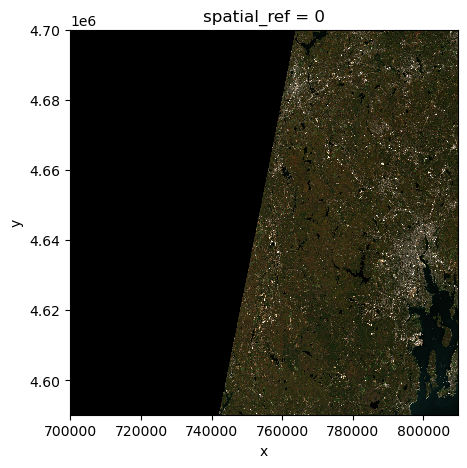

In [27]:
worcester_overview.plot.imshow(size=5, aspect=1)

## Clipping a Raster

You can use the `.rio.clip()` function to clip your raster.

Let's define a geometry for clipping:

In [28]:
from shapely.geometry import box

min_x = 760000
min_y = 4620000
max_x = 790000
max_y = 4660000

clipping_geom = box(min_x, min_y, max_x, max_y)

In [29]:
worcester_overview.rio.clip([clipping_geom])

<xarray.DataArray (band: 3, y: 1000, x: 750)> Size: 2MB
array([[[  2,   3,   3, ...,  30,  40,  51],
        [  3,   2,   2, ...,  56,  44,  52],
        [  3,   2,   2, ...,  42,  40,  43],
        ...,
        [ 33,  63, 125, ...,  35,  35,  29],
        [ 49,  48, 110, ...,  41,  37,  53],
        [ 40,  41,  85, ...,  36,  23,  62]],

       [[  8,   9,   9, ...,  35,  40,  52],
        [  9,   9,   9, ...,  41,  39,  50],
        [ 10,   9,   9, ...,  36,  32,  36],
        ...,
        [ 40,  54,  81, ...,  41,  36,  26],
        [ 42,  51,  77, ...,  42,  38,  49],
        [ 39,  46,  60, ...,  36,  23,  55]],

       [[  4,   5,   6, ...,  10,  10,  33],
        [  5,   5,   5, ...,  18,  13,  31],
        [  5,   6,   5, ...,  14,  11,  11],
        ...,
        [ 18,  29,  53, ...,  20,  17,  12],
        [ 22,  23,  50, ...,  24,  16,  25],
        [ 18,  21,  38, ...,  20,   6,  36]]], dtype=uint8)
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 6kB 7.6e+05 7.601e+05 ... 7.899e+05 7.9e+05
  * y            (y) float64 8kB 4.66e+06 4.66e+06 ... 4.62e+06 4.62e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    scale_factor:        1.0
    add_offset:          0.0
    _FillValue:          0

Another way to clip your raster, is using `slice_xy` to slice the array by x,y bounds. In this case, and unlike `clip` you do not need a geojson like geometry dict. Here is how it works:

In [30]:
worcester_overview.rio.slice_xy(min_x, min_y, max_x, max_y)

<xarray.DataArray (band: 3, y: 1000, x: 750)> Size: 2MB
[2250000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 6kB 7.6e+05 7.601e+05 ... 7.899e+05 7.9e+05
  * y            (y) float64 8kB 4.66e+06 4.66e+06 ... 4.62e+06 4.62e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

While `clip` and `slice_xy` seem to work the same way, `clip` has more functionality and several arguments that can customize the task. Check the description [here](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray.raster_array.RasterArray.clip). 

You can also use the built-in `xarray.sel()` method to select values for specific values across each coordinate. For example, we can select the value as following: 

In [31]:
worcester_overview.sel(x=[761000], y=[4630000], method="nearest")

<xarray.DataArray (band: 3, y: 1, x: 1)> Size: 3B
[3 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 8B 7.61e+05
  * y            (y) float64 8B 4.63e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

The argument `method` is needed when the provided `x` and `y` are not the actual value present in the requested coordinate. `Xarray` will use the `method` to interpolate the values and find the corresponding value for the requested coordinate. 

## Handling Large Rasters

When using `xarray.open_rasterio` (and in general any open_dataset function in `xarray` the data is loaded from the underlying datastore in memory as NumPy arrays by default. 

But you may want to avoid this if you are working with a very large dataset. To do that, you can either pass the `cache = False` argument to `xarray.open_rasterio` or specify the chunks argument to use Dask. 

In [32]:
worcester_nir_xr_not_cached = rxr.open_rasterio(item[0].assets["nir"].href, cache = False)

From here, you can work with the `DataArray` as before and `xarray` will only load the parts of `DataArray` that you request. For example, if you use `sel` to retrieve a value, it will only read that part of the `DataArray`:

In [33]:
worcester_nir_xr_not_cached.sel(x=[761000], y=[4630000], method="nearest")

<xarray.DataArray (band: 1, y: 1, x: 1)> Size: 2B
[1 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8B 7.61e+05
  * y            (y) float64 8B 4.63e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

## Writing Data to Disk

You can use the `.rio.to_raster` function to write a `rioxarray.DataArray` to disk. Let's write the clipped version of our multi-band imagery to disk:

In [34]:
worcester_clipped = worcester_overview.rio.clip([clipping_geom])

In [35]:
worcester_clipped.rio.to_raster("worcester_clipped.tif")

## Exercise 2
Question: What do `x` and `y` represent? Are they the center coordinates of each pixel, or the edge?